# CR3BP : N-body Simulator

This notebook version provide the script-based simulator structure (solve_ivp, 3D trajectories, multiple scenario modes) in a compact manner to enable easy visualisation.
Run using the script instead for better 3d visualisation with matplotlib.

Modes:
- `cr3bp_lagrangepoint`: start near a chosen L-point (L1–L5)
- `cr3bp_random`: random test-particle initial condition
- `manual_nbody`: user-specified bodies (N ≥ 2)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from astropy import constants as const
from astropy import units as u

## Default bodies for CR3BP modes


In [11]:
PRIMARYNAME = "Earth"
SECONDARYNAME = "Moon"

MPRIMARY = const.M_earth
MSECONDARY = 7.34767309e22 * u.kg
mu = (MSECONDARY / (MPRIMARY + MSECONDARY)).decompose().value
#mu = 0.1 #uncomment to test other mu values 
print(f"Default system: {PRIMARYNAME}-{SECONDARYNAME} | mu={mu:.12f}")

Default system: Earth-Moon | mu=0.012153663633


## Simulation parameters

Uses the non-dimensional convention: with primaries at x=-μ and x=1-μ with angular rate 1 about z for CR3BP case.


In [41]:
Gnd = 1.0
softening = 1e-6

tfinal = 10.0
targetdt = 0.02
minpoints = 800
maxpoints = 6000

rtol = 1e-9
atol = 1e-12
method = "RK45"

max_step_factor = 1.0

plotstride = 1
show_initial_markers = True
massless_body_linewidth = 1.5  # default 1.5 for regular/infinite bodies

## Core utilities


In [ ]:
def packstate(positions, velocities):
    return np.hstack([positions.ravel(), velocities.ravel()])


def unpackstate(y, nbodies):
    positions = y[: 3 * nbodies].reshape(nbodies, 3)
    velocities = y[3 * nbodies :].reshape(nbodies, 3)
    return positions, velocities


def validatebodies(
    bodies,
    *,
    enforce_manual_bounds=False,
    manual_mass_range=(1e-6, 1e3),
    manual_pos_range=(-10.0, 10.0),
    manual_vel_range=(-10.0, 10.0),
):
    if not isinstance(bodies, (list, tuple)) or len(bodies) == 0:
        raise ValueError("bodies must be a non-empty list of dicts")

    allowed = {"regular", "massless", "infinite"}
    if sum(1 for b in bodies if b.get("kind") == "infinite") > 1:
        raise ValueError("At most one body may have kind='infinite'")

    m_min, m_max = manual_mass_range
    p_min, p_max = manual_pos_range
    v_min, v_max = manual_vel_range

    for i, b in enumerate(bodies):
        if b.get("kind") not in allowed:
            raise ValueError(f"Body {i}: kind must be one of {sorted(allowed)}")
        if "mass" not in b:
            raise ValueError(f"Body {i}: missing mass")
        if "state" not in b or len(b["state"]) != 6:
            raise ValueError(f"Body {i}: state must be [x,y,z,vx,vy,vz]")

        mass = float(b["mass"])
        if not np.isfinite(mass) or mass < 0:
            raise ValueError(f"Body {i}: mass must be finite and >= 0")

        state = np.array(b["state"], dtype=float)
        if not np.all(np.isfinite(state)):
            raise ValueError(f"Body {i}: state contains NaN/Inf")

        if enforce_manual_bounds:
            x, y, z, vx, vy, vz = state
            kind = b.get("kind")
            if kind in ("regular", "infinite"):
                if not (m_min <= mass <= m_max):
                    raise ValueError(
                        f"Body {i}: mass {mass} outside [{m_min}, {m_max}] for kind='{kind}'."
                    )
            if not (p_min <= x <= p_max and p_min <= y <= p_max and p_min <= z <= p_max):
                raise ValueError(
                    f"Body {i}: position components must lie in [{p_min}, {p_max}] in manual mode."
                )
            if not (v_min <= vx <= v_max and v_min <= vy <= v_max and v_min <= vz <= v_max):
                raise ValueError(
                    f"Body {i}: velocity components must lie in [{v_min}, {v_max}] in manual mode."
                )


def bodiestoarrays(bodies):
    names = [b.get("name", f"Body{i}") for i, b in enumerate(bodies)]
    kinds = np.array([b["kind"] for b in bodies], dtype=object)
    masses = np.array([float(b["mass"]) for b in bodies], dtype=float)
    state = np.array([b["state"] for b in bodies], dtype=float)
    pos0 = state[:, 0:3]
    vel0 = state[:, 3:6]
    return names, kinds, masses, pos0, vel0


def computeaccelerations(positions, masses, kinds, G=1.0, eps=0.0):
    # massless bodies do not act as gravity sources
    sourcemasses = masses.copy()
    sourcemasses[kinds == "massless"] = 0.0

    # rij = r_j - r_i
    rij = positions[None, :, :] - positions[:, None, :]
    dist2 = np.sum(rij * rij, axis=2) + eps**2
    invdist3 = dist2 ** (-1.5)
    np.fill_diagonal(invdist3, 0.0)

    acc = G * np.sum(rij * invdist3[:, :, None] * sourcemasses[None, :, None], axis=1)

    # infinite body: exerts gravity but does not feel gravity
    acc[kinds == "infinite"] = 0.0
    return acc


def nbodyrhs(t, y, masses, kinds, G=1.0, eps=0.0):
    n = masses.size
    pos, vel = unpackstate(y, n)
    acc = computeaccelerations(pos, masses, kinds, G=G, eps=eps)
    return packstate(vel, acc)


def maketimegrid(tfinal, dttarget, nmin, nmax):
    nideal = int(np.ceil(tfinal / dttarget)) + 1
    n = int(np.clip(nideal, nmin, nmax))
    teval = np.linspace(0.0, tfinal, n)
    dt = teval[1] - teval[0] if n > 1 else tfinal
    return teval, dt

## CR3BP helpers (L-points + default primaries)


In [ ]:
def computelagrangepoints(mu):
    # Same Newton approach as the Lagrange notebook
    def dOmegadxonxaxis(x):
        x1, x2 = -mu, 1.0 - mu
        r1, r2 = abs(x - x1), abs(x - x2)
        if r1 == 0.0 or r2 == 0.0:
            return np.inf
        return x - (1.0 - mu) * (x - x1) / r1**3 - mu * (x - x2) / r2**3

    def d2Omegadx2numeric(x, h=1e-8):
        return (dOmegadxonxaxis(x + h) - dOmegadxonxaxis(x - h)) / (2.0 * h)

    def newton(x0, tol=1e-14, maxiter=80):
        x = x0
        for _ in range(maxiter):
            f = dOmegadxonxaxis(x)
            fp = d2Omegadx2numeric(x)
            if not np.isfinite(f) or not np.isfinite(fp) or fp == 0.0:
                break
            xn = x - f / fp
            if abs(xn - x) < tol:
                return xn
            x = xn
        raise RuntimeError("Newton solve failed")

    gamma0 = (mu / 3.0) ** (1.0 / 3.0)
    xL1 = newton(1.0 - mu - gamma0)
    xL2 = newton(1.0 - mu + gamma0)
    xL3 = newton(-1.0 - 5.0 * mu / 12.0)
    xL4, yL4 = 0.5 - mu, np.sqrt(3.0) / 2.0
    xL5, yL5 = xL4, -yL4

    return {
        "L1": np.array([xL1, 0.0]),
        "L2": np.array([xL2, 0.0]),
        "L3": np.array([xL3, 0.0]),
        "L4": np.array([xL4, yL4]),
        "L5": np.array([xL5, yL5]),
    }


def builddefaultcr3bpbodies(mu, teststatexyzvxyz, labelprimary="Primary", labelsecondary="Secondary"):
    # Primaries on circular motion in inertial coords with omega = +z
    m1, m2 = 1.0 - mu, mu
    r1 = np.array([-mu, 0.0, 0.0])
    r2 = np.array([1.0 - mu, 0.0, 0.0])
    omega = np.array([0.0, 0.0, 1.0])
    v1 = np.cross(omega, r1)
    v2 = np.cross(omega, r2)

    bodies = [
        {"name": labelprimary, "kind": "regular", "mass": m1, "state": [*r1, *v1]},
        {"name": labelsecondary, "kind": "regular", "mass": m2, "state": [*r2, *v2]},
        {"name": "TestBody", "kind": "massless", "mass": 1.0, "state": list(teststatexyzvxyz)},
    ]
    return bodies

## Simulation and plotting


In [32]:
def runsimulation(
    bodies,
    tfinal=40.0,
    *,
    enforce_manual_bounds=False,
    manual_mass_range=(1e-6, 1e3),
    manual_pos_range=(-10.0, 10.0),
    manual_vel_range=(-10.0, 10.0),
):
    validatebodies(
        bodies,
        enforce_manual_bounds=enforce_manual_bounds,
        manual_mass_range=manual_mass_range,
        manual_pos_range=manual_pos_range,
        manual_vel_range=manual_vel_range,
    )

    names, kinds, masses, pos0, vel0 = bodiestoarrays(bodies)
    y0 = packstate(pos0, vel0)

    teval, dtused = maketimegrid(tfinal, targetdt, minpoints, maxpoints)
    maxstep = max_step_factor * dtused

    sol = solve_ivp(
        fun=lambda t, y: nbodyrhs(t, y, masses, kinds, G=Gnd, eps=softening),
        t_span=(teval[0], teval[-1]),
        y0=y0,
        t_eval=teval,
        method=method,
        rtol=rtol,
        atol=atol,
        max_step=maxstep,
    )

    if not sol.success:
        raise RuntimeError(f"solve_ivp failed: {sol.message}")

    Y = sol.y.T
    n = masses.size
    traj = Y[:, : 3 * n].reshape(-1, n, 3)
    return sol, names, kinds, masses, traj, dtused


def plottrajectories(names, kinds, traj, title, stride=1):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")
    idx = slice(None, None, stride)

    for i, nm in enumerate(names):
        lw = massless_body_linewidth if kinds[i] == "massless" else 1.5
        ax.plot(traj[idx, i, 0], traj[idx, i, 1], traj[idx, i, 2], lw=lw, label=f"{nm} ({kinds[i]})")
        if show_initial_markers:
            ax.scatter(traj[0, i, 0], traj[0, i, 1], traj[0, i, 2], s=25)

    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.legend(fontsize=8, ncol=2)
    plt.tight_layout()
    plt.show()

## Mode 1 CR3BP L-point start


Mode:cr3bp_lagrangepoint L4 N=3 steps=800 dt=0.0125


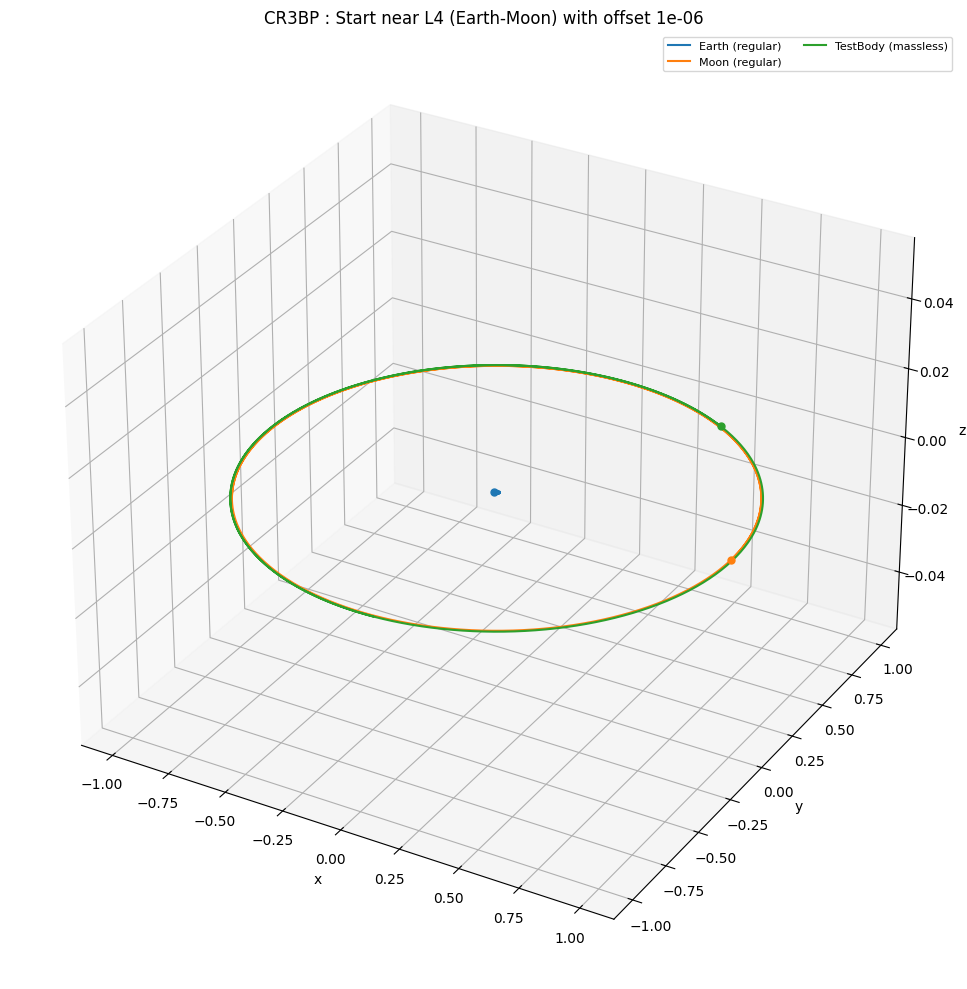

In [42]:
# User parameters (Mode 1)
Llabel = "L4"  # "L1".."L5"
offsetr = 1e-6
seed_offset = 1

# Build initial conditions
L = computelagrangepoints(mu)
if Llabel not in L:
    raise ValueError("Llabel must be one of 'L1'..'L5'")

rng = np.random.default_rng(seed_offset)
angle = rng.uniform(0.0, 2.0 * np.pi)
offsetxy = offsetr * np.array([np.cos(angle), np.sin(angle)])

base_xy = L[Llabel]
rtest = np.array([base_xy[0] + offsetxy[0], base_xy[1] + offsetxy[1], 0.0])

omega = np.array([0.0, 0.0, 1.0])
vtest = np.cross(omega, rtest)

bodies = builddefaultcr3bpbodies(mu, [*rtest, *vtest], labelprimary=PRIMARYNAME, labelsecondary=SECONDARYNAME)
sol, names, kinds, masses, traj, dtused = runsimulation(bodies, tfinal=tfinal)

print(f"Mode:cr3bp_lagrangepoint {Llabel} N={len(bodies)} steps={sol.t.size} dt={dtused:.4f}")
plottrajectories(
    names,
    kinds,
    traj,
    title=f"CR3BP : Start near {Llabel} ({PRIMARYNAME}-{SECONDARYNAME}) with offset {offsetr}",
    stride=plotstride,
)

## Mode 2 CR3BP random start


Mode:cr3bp_random done N=3 steps=800 dt=0.0125


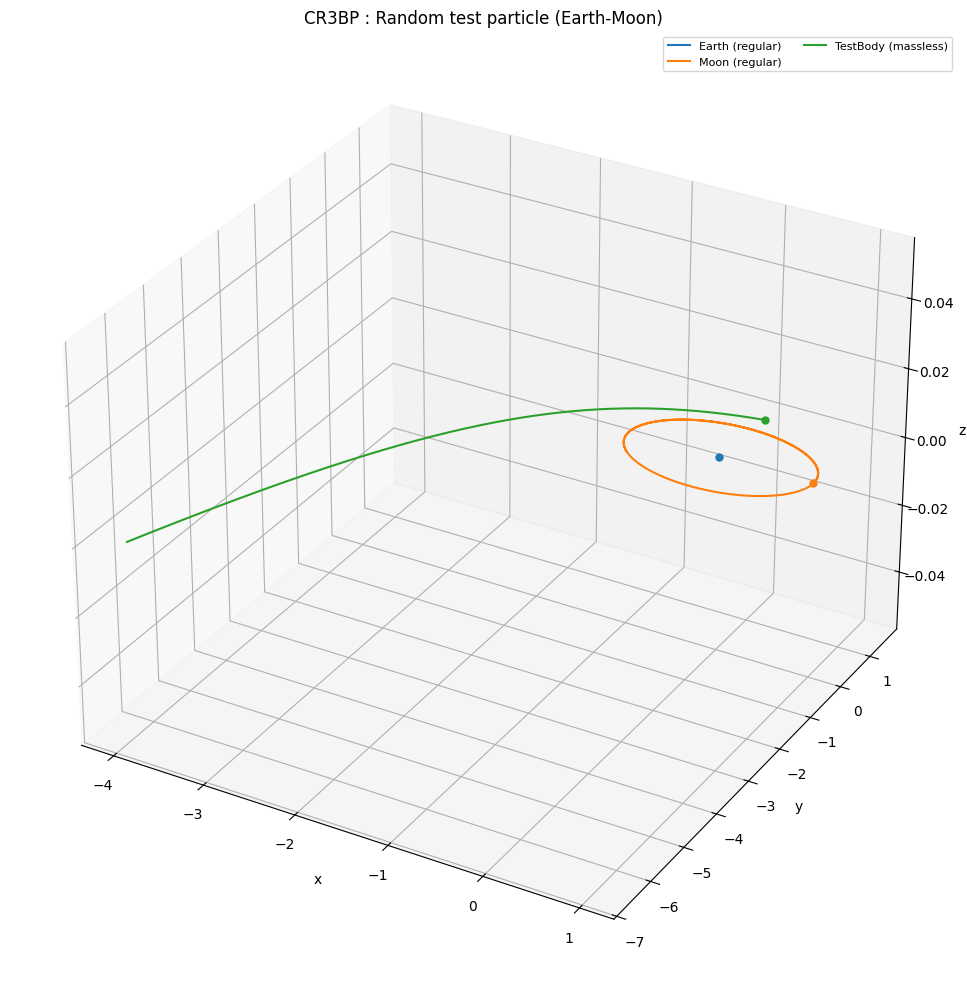

In [44]:
# User parameters (Mode 2)
cr3bp_random_use_random = True
cr3bp_random_position_box = (-1.5, 1.5)
cr3bp_random_velocity_scale = 0.3
seed_random = 1
cr3bp_random_user_state = (0.2, 0.1, 0.0, 0.0, 0.25, 0.0)  # (x,y,z,vx_rot,vy_rot,vz_rot) (use for manual config)

# Build initial conditions
rng = np.random.default_rng(seed_random)

if cr3bp_random_use_random:
    x_min, x_max = cr3bp_random_position_box
    rx = rng.uniform(x_min, x_max)
    ry = rng.uniform(x_min, x_max)
    rz = 0.0
    vx_rot = rng.normal(scale=cr3bp_random_velocity_scale)
    vy_rot = rng.normal(scale=cr3bp_random_velocity_scale)
    vz_rot = 0.0
else:
    rx, ry, rz, vx_rot, vy_rot, vz_rot = cr3bp_random_user_state

rtest = np.array([rx, ry, rz])
vrot = np.array([vx_rot, vy_rot, vz_rot])
omega = np.array([0.0, 0.0, 1.0])
vtest = np.cross(omega, rtest) + vrot

bodies = builddefaultcr3bpbodies(mu, [*rtest, *vtest], labelprimary=PRIMARYNAME, labelsecondary=SECONDARYNAME)
sol, names, kinds, masses, traj, dtused = runsimulation(bodies, tfinal=tfinal)

print(f"Mode:cr3bp_random done N={len(bodies)} steps={sol.t.size} dt={dtused:.4f}")
plottrajectories(
    names,
    kinds,
    traj,
    title=f"CR3BP : Random test particle ({PRIMARYNAME}-{SECONDARYNAME})",
    stride=plotstride,
)

## Mode 3 Manual N-body

Example with 4 bodies (two regular gravitating, one infinite mass, one massless test particle).

Mode:manualnbody done N=4 steps=800 dt=0.0125


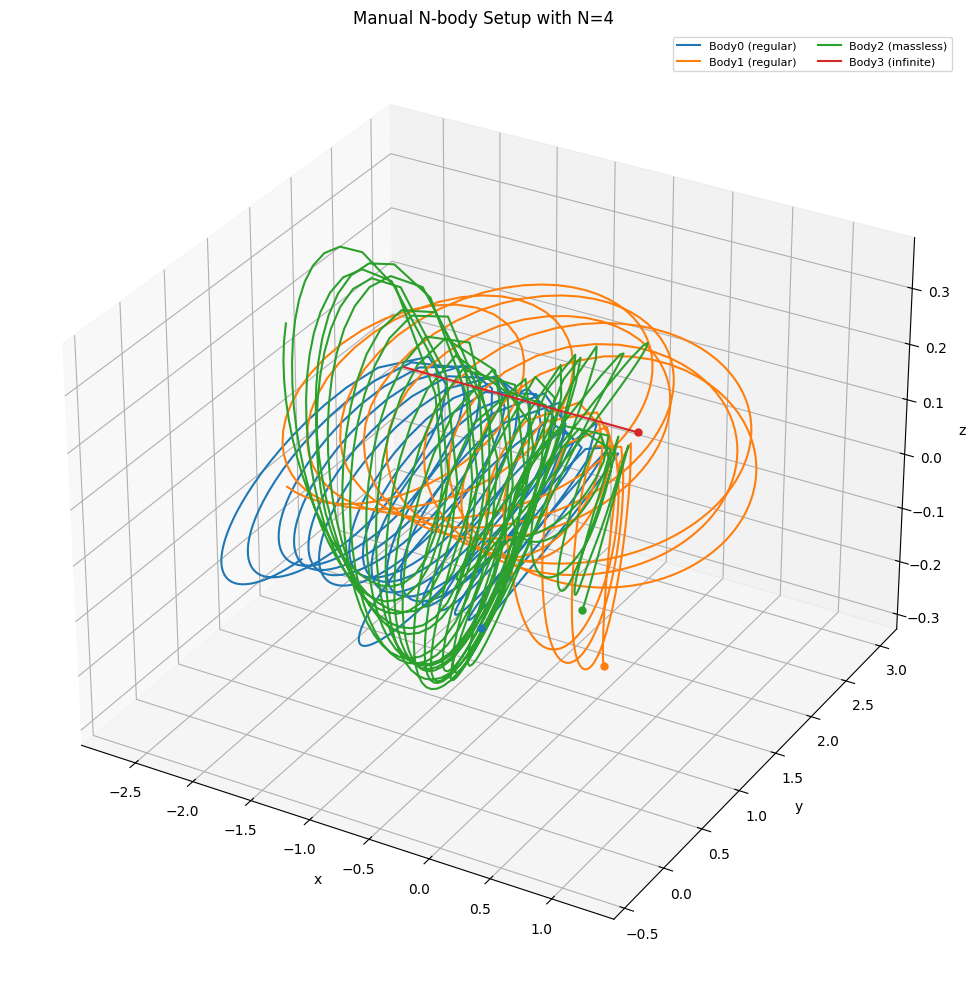

In [45]:
# User parameters (Mode 3)
MANUAL_MASS_RANGE = (1e-6, 1e3)   # for regular/infinite bodies
MANUAL_POS_RANGE = (-10.0, 10.0)  # per component
MANUAL_VEL_RANGE = (-10.0, 10.0)  # per component

manualbodies = [
    {"name": "Body0", "kind": "regular",  "mass": 1.0, "state": (0.0, 0.0, 0.0, 0.0,  0.25, 0.0)},
    {"name": "Body1", "kind": "regular",  "mass": 0.5, "state": (1.0, 0.0, 0.0, 0.0, -0.30, 0.0)},
    {"name": "Body2", "kind": "massless", "mass": 1.0, "state": (0.5, 0.5, 0.0, 0.1,  0.00, 0.0)},
    {"name": "Body3", "kind": "infinite", "mass": 100.0, "state": (0.0, 2.0, 0.1, -0.2, 0.00, 0.0)},
]

sol, names, kinds, masses, traj, dtused = runsimulation(
    manualbodies,
    tfinal=tfinal,
    enforce_manual_bounds=True,
    manual_mass_range=MANUAL_MASS_RANGE,
    manual_pos_range=MANUAL_POS_RANGE,
    manual_vel_range=MANUAL_VEL_RANGE,
)

print(f"Mode:manualnbody done N={len(manualbodies)} steps={sol.t.size} dt={dtused:.4f}")
plottrajectories(names, kinds, traj, title=f"Manual N-body Setup with N={len(manualbodies)}", stride=plotstride)